# XGBoost

This notebook analyzes the `credit_risk_dataset.csv` to build a credit scoring model. It includes:
1. Dataset exploration and description.
2. Data visualization.
3. Feature Engineering.
4. Model Training and Evaluation.


## 1. Dataset Exploration and Description

In [57]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier

In [37]:
#Load the dataset into a pandas DataFrame and display basic information.
df = pd.read_csv('credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [12]:
df.person_home_ownership.value_counts()

person_home_ownership
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: count, dtype: int64

In [18]:
df.loan_grade.value_counts()

loan_grade
A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: count, dtype: int64

In [20]:
df.loan_intent.value_counts()

loan_intent
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64

In [33]:
df.loan_status.value_counts()

loan_status
0    25473
1     7108
Name: count, dtype: int64

## 2. Data Visualization

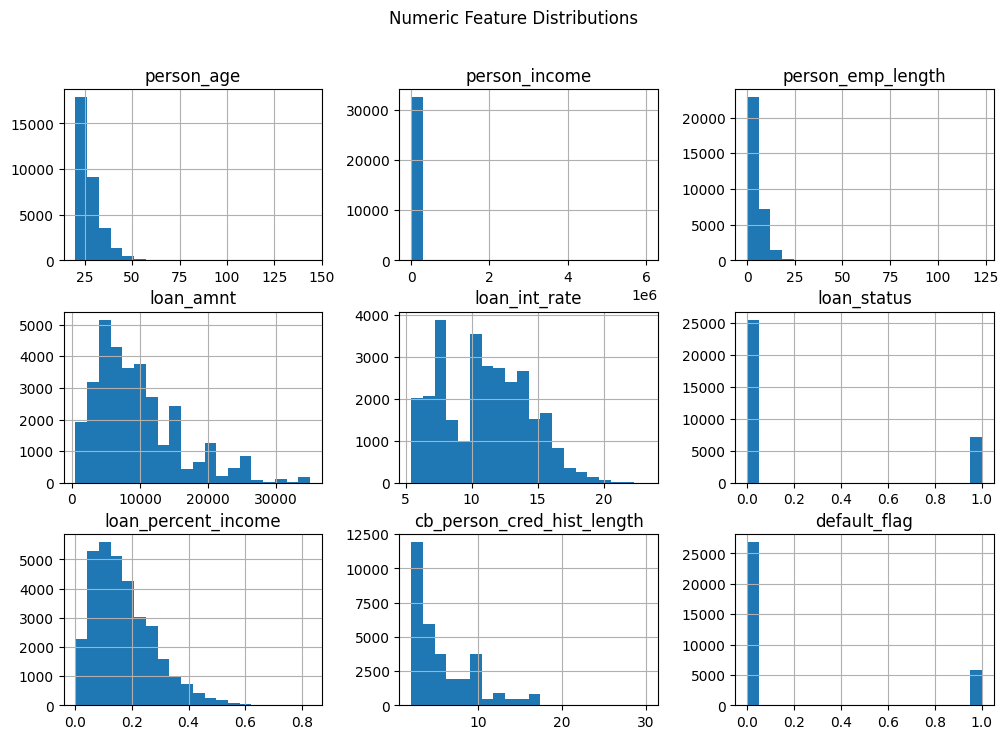

In [23]:
# Comment: Visualize the distribution of numeric features.
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle("Numeric Feature Distributions")
plt.show()

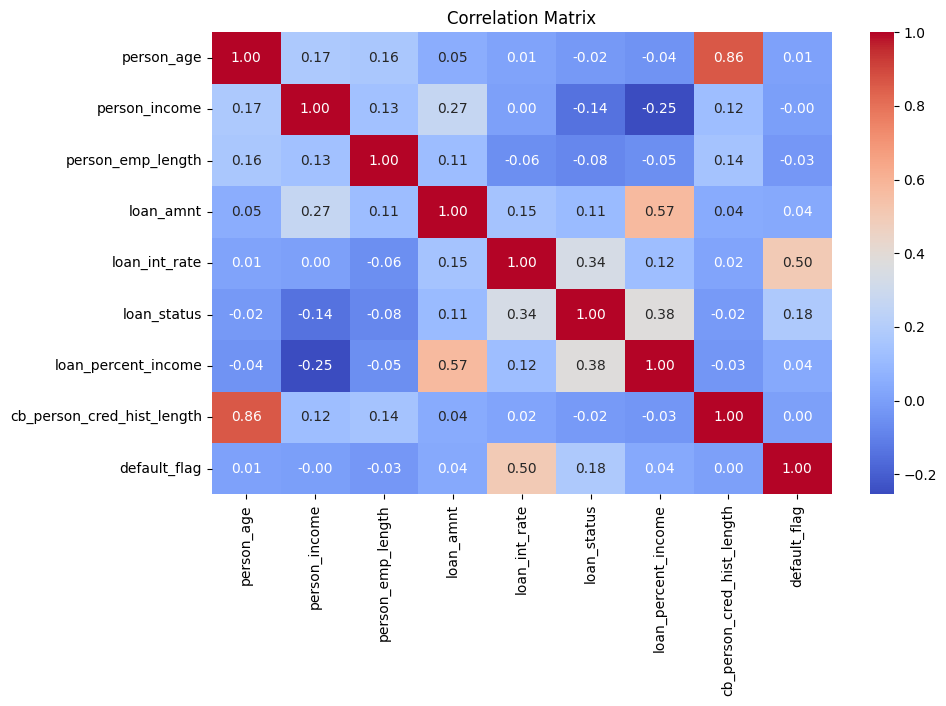

In [24]:
# Comment: Visualize the correlation matrix.
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

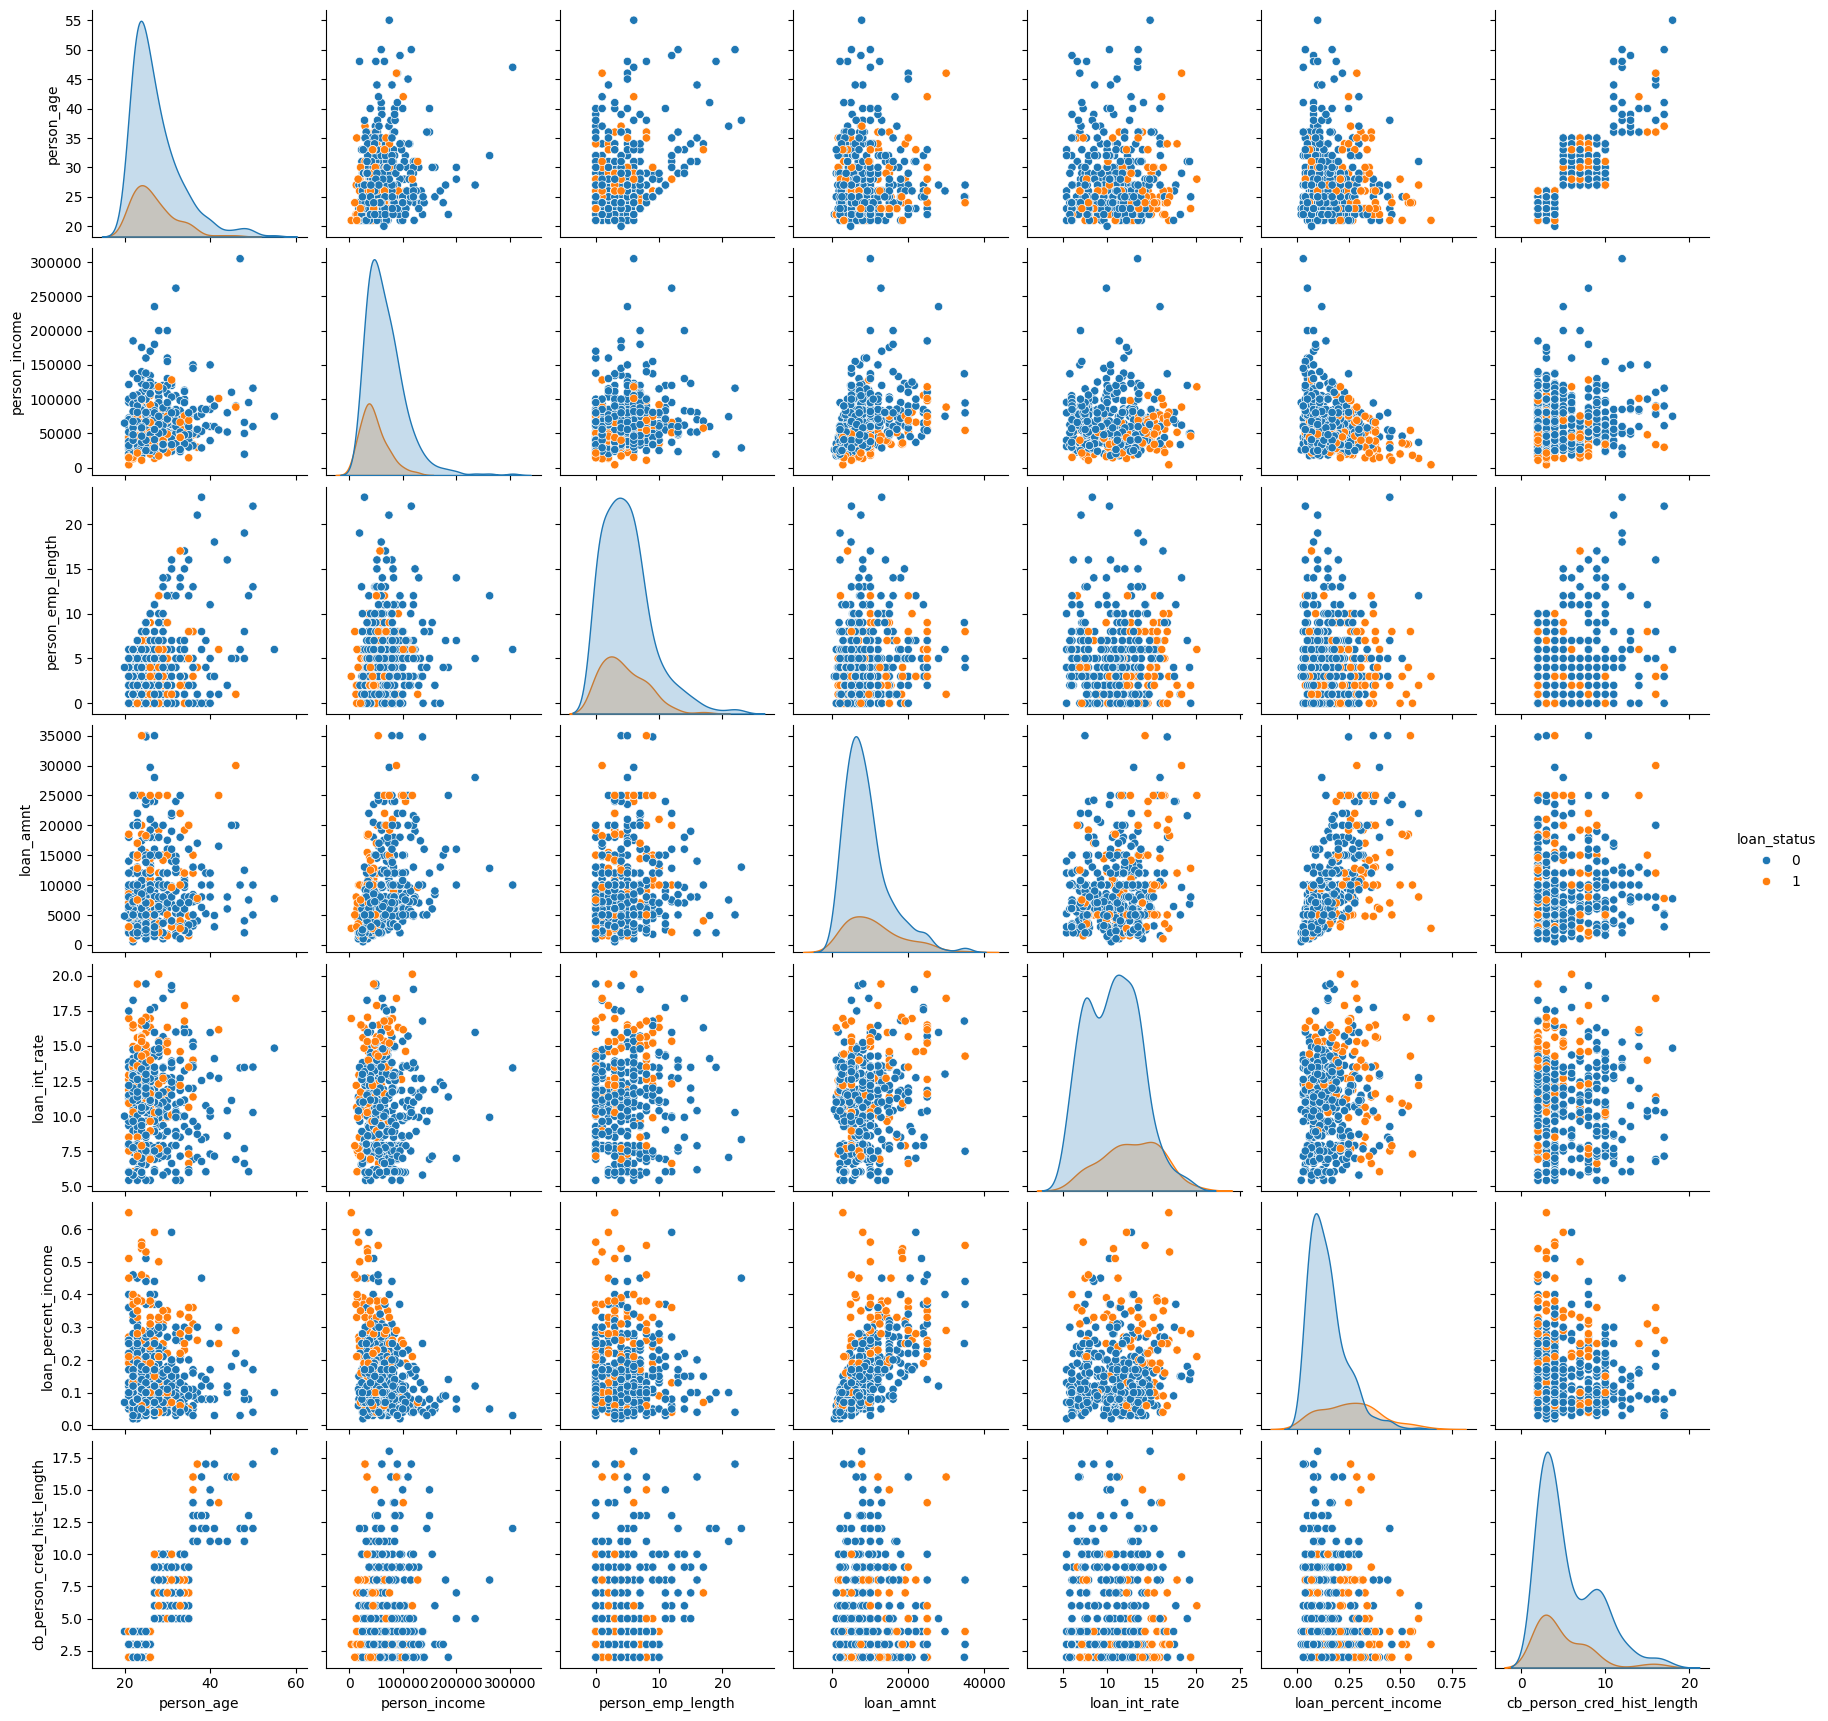

In [41]:
sns.pairplot(df.sample(500), hue="loan_status")
plt.show()

In [ ]:
sns.pairplot(df.sample(500), hue="cb_person_default_on_file")
plt.show()

From the graphs above we can see that some features high correlated to the target 'loan_status', those features are: 'loan_percent_income', 'loan_int_rate', 'loan_amnt', 'person_income', and 'person_emp_length'.

## Feature Engineering

In [45]:
# Create loan-to-income ratio
df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']

# Create loan-to-employment length ratio
df['loan_to_emp_length_ratio'] =  df['person_emp_length']/ df['loan_amnt']

# Create interest rate-to-loan amount ratio
df['int_rate_to_loan_amt_ratio'] = df['loan_int_rate'] / df['loan_amnt']

In [46]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_to_income_ratio,loan_to_emp_length_ratio,int_rate_to_loan_amt_ratio
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,0.593220,0.003514,0.000458
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,0.104167,0.005000,0.011140
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,0.572917,0.000182,0.002340
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,0.534351,0.000114,0.000435
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,0.643382,0.000229,0.000408


In [94]:
#Prepare features (X) by dropping the target ('loan_status') and potentially leakage-prone column ('cb_person_default_on_file'), and set the target variable (y) to 'loan_status'.
X = df.drop(['loan_status', 'cb_person_default_on_file'], axis=1)
y = df['loan_status']    

In [48]:
# Perform one-hot encoding
X = pd.get_dummies(X)

# Print the result
X.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_to_income_ratio,loan_to_emp_length_ratio,int_rate_to_loan_amt_ratio,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
0,22,59000,123.0,35000,16.02,0.59,3,0.593220,0.003514,0.000458,...,False,True,False,False,False,False,True,False,False,False
1,21,9600,5.0,1000,11.14,0.10,2,0.104167,0.005000,0.011140,...,False,False,False,False,True,False,False,False,False,False
2,25,9600,1.0,5500,12.87,0.57,3,0.572917,0.000182,0.002340,...,True,False,False,False,False,True,False,False,False,False
3,23,65500,4.0,35000,15.23,0.53,2,0.534351,0.000114,0.000435,...,True,False,False,False,False,True,False,False,False,False
4,24,54400,8.0,35000,14.27,0.55,4,0.643382,0.000229,0.000408,...,True,False,False,False,False,True,False,False,False,False


In [95]:
#split dataset into training data and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [96]:
X_train.shape, X_test.shape

((26064, 13), (6517, 13))

## 4. Model Training and Evaluation

In [99]:
# Convert object columns to category type
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade']
X_train[categorical_columns] = X_train[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')

# Re-run the model training
model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, enable_categorical=True, scale_pos_weight=3)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [100]:
test_accuracy = accuracy_score(y_test, y_pred)
test_report = classification_report(y_test, y_pred)

print("Testing Set Accuracy:", test_accuracy)
print("Testing Set Classification Report:\n", test_report)

Testing Set Accuracy: 0.9323308270676691
Testing Set Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.97      0.71      0.82      1422

    accuracy                           0.93      6517
   macro avg       0.95      0.85      0.89      6517
weighted avg       0.93      0.93      0.93      6517



In [102]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy:{accuracy: .2f}")

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision: .2f}")

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall: .2f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1: .2f}")

Accuracy: 0.93
Precision:  0.97
Recall:  0.71
F1 Score:  0.82


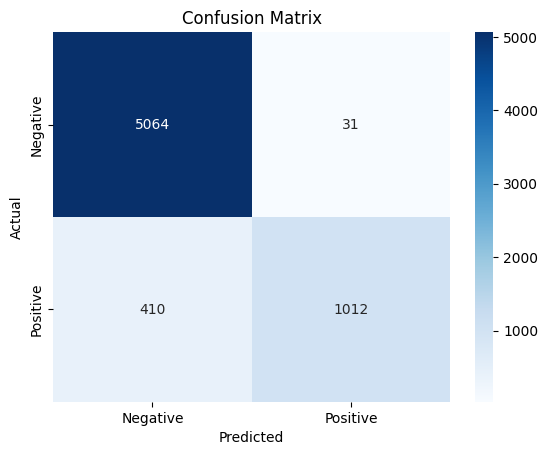

In [103]:
# Assuming y_test and y_pred are your true labels and predicted labels, respectively
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

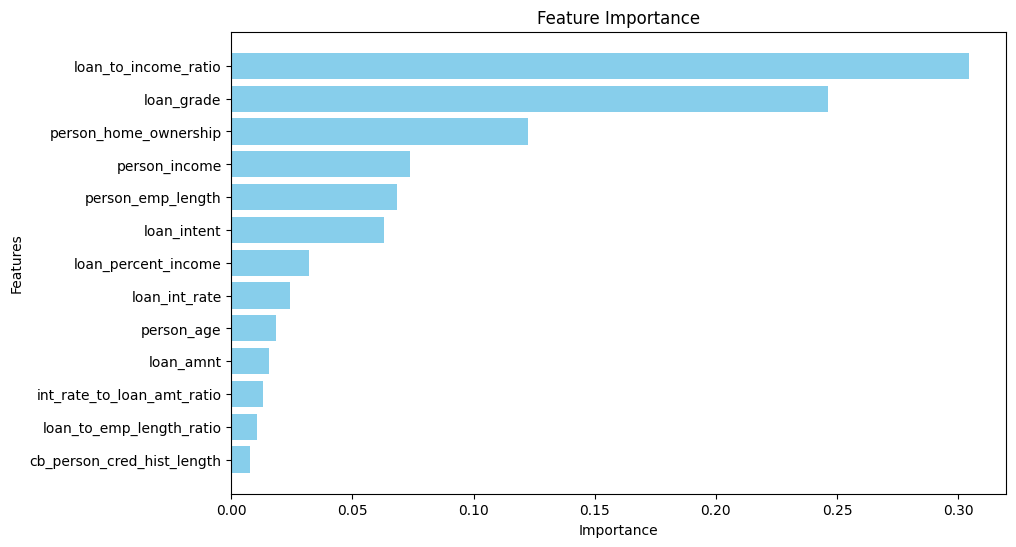

In [104]:
# Get feature importance
feature_importance = model.feature_importances_
features = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()